# 1. Exploration

In [1]:
# Imports

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from matplotlib.patches import Patch
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D

from sklearn.linear_model import LinearRegression

no_top_left_bar = {"axes.spines.right": False, "axes.spines.top": False}

In [2]:
# Data Loading

data_dir = '/kaggle/input/fitbit/Fitabase Data 4.12.16-5.12.16'
df_heartrate = pd.read_csv(data_dir + '/heartrate_seconds_merged.csv').dropna().sort_values('Id')

def split_date_and_time_from_df(df_in: pd.DataFrame, column:str = 'Time') -> pd.DataFrame:
# Split time through expand
	df_split_time = df_in[column].str.split(' ', expand=True)

	dict_rename_columns = {
		0: 'Date',
		1: 'Time',
		2: 'AM_PM'
	}

	df_split_time = df_split_time.rename(columns=dict_rename_columns)
	df_split_time.loc[:, 'Date'] = pd.to_datetime(df_split_time.loc[:, 'Date'])
	
	return pd.merge(left=df_in.drop(columns=column), right=df_split_time, right_index=True, left_index=True)

df_heartrate = split_date_and_time_from_df(df_heartrate)
df_heartrate.head()

,Id,Value,Date,Time,AM_PM
0,2022484408,97,2016-04-12 00:00:00,7:21:00,AM
102732,2022484408,73,2016-05-02 00:00:00,3:59:15,PM
102733,2022484408,74,2016-05-02 00:00:00,3:59:20,PM
102734,2022484408,76,2016-05-02 00:00:00,3:59:25,PM
102735,2022484408,75,2016-05-02 00:00:00,3:59:30,PM


In [9]:
print('NA values: ', df_heartrate.isna().sum().sum())
df_heartrate.info()

NA values:  0
<class 'pandas.core.frame.DataFrame'>
Index: 2483658 entries, 0 to 2483657
Data columns (total 6 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Value   int64 
 2   Date    object
 3   Time    object
 4   AM_PM   object
 5   Name    object
dtypes: int64(2), object(4)
memory usage: 197.1+ MB


In [10]:
# Adding random names to facilitate the reading of the analysis

names = ["James", "Mary", "Robert", "Patricia", "John", "Jennifer", "Michael", "Linda", "William", "Elizabeth", "David", "Barbara", "Richard", "Susan", "Joseph", "Jessica", "Thomas", "Sarah", "Charles", "Karen", "Christopher", "Nancy", "Daniel", "Lisa", "Matthew", "Betty", "Anthony", "Margaret", "Mark", "Sandra", "Donald", "Ashley", "Steven", "Kimberly", "Paul", "Emily", "Andrew", "Donna", "Joshua", "Michelle", "Kenneth", "Dorothy", "Kevin", "Carol", "Brian", "Amanda", "George", "Melissa", "Edward", "Deborah", "Ronald", "Stephanie", "Timothy", "Rebecca", "Jason", "Sharon", "Jeffrey", "Laura", "Ryan", "Cynthia", "Jacob", "Kathleen", "Gary", "Amy", "Nicholas", "Shirley", "Eric", "Angela", "Jonathan", "Helen", "Stephen", "Anna", "Larry", "Brenda", "Justin", "Pamela", "Scott", "Nicole", "Brandon", "Emma", "Benjamin", "Samantha", "Samuel", "Katherine", "Gregory", "Christine", "Frank", "Debra", "Alexander"]

dict_ids_names = {}
for i, i_name in enumerate(df_heartrate['Id'].unique()):
    dict_ids_names[i_name] = names[i]
    
# Saving for consitency with other analysis
pd.DataFrame.from_dict(data=dict_ids_names, orient='index', columns=['Names']).to_csv('id_to_names.csv')

df_heartrate.loc[:, 'Name'] = df_heartrate['Id'].replace(dict_ids_names)
df_heartrate.head()

,Id,Value,Date,Time,AM_PM,Name
0,2022484408,97,2016-04-12 00:00:00,7:21:00,AM,James
102732,2022484408,73,2016-05-02 00:00:00,3:59:15,PM,James
102733,2022484408,74,2016-05-02 00:00:00,3:59:20,PM,James
102734,2022484408,76,2016-05-02 00:00:00,3:59:25,PM,James
102735,2022484408,75,2016-05-02 00:00:00,3:59:30,PM,James


Number of entries per user

In [11]:
hr_value_count = df_heartrate[['Id', 'Value']].groupby('Id').count().sort_values('Value', ascending=False)
hr_value_count.T

Id,4020332650,6962181067,5553957443,4388161847,5577150313,8877689391,4558609924,6117666160,2022484408,2347167796,7007744171,8792009665,6775888955,2026352035
Value,285461,266326,255174,249748,248560,228841,192168,158899,154104,152683,133592,122841,32771,2490


In [12]:
def keep_minimum_amount_values(df_in: pd.DataFrame) -> pd.DataFrame:
	min_to_keep = 100_000

	vals = df_in.groupby('Id').count().drop(columns='Time').sort_values('Value', ascending=False)
	ids_to_keep = hr_value_count[hr_value_count['Value'] > min_to_keep].index
	df_out = df_in[df_in['Id'].isin(ids_to_keep)]
	
	print(f'Rows dropped due to ID due to having less than {min_to_keep} values: ', len(df_in) - len(df_out))
	return df_out

df_heartrate_reduced = keep_minimum_amount_values(df_heartrate)
df_heartrate_reduced.head()

Rows dropped due to ID due to having less than 100000 values:  35261


,Id,Value,Date,Time,AM_PM,Name
0,2022484408,97,2016-04-12 00:00:00,7:21:00,AM,James
102732,2022484408,73,2016-05-02 00:00:00,3:59:15,PM,James
102733,2022484408,74,2016-05-02 00:00:00,3:59:20,PM,James
102734,2022484408,76,2016-05-02 00:00:00,3:59:25,PM,James
102735,2022484408,75,2016-05-02 00:00:00,3:59:30,PM,James


In [13]:
# Checking the dates that are in the DF

print(df_heartrate_reduced['Date'].sort_values().unique())

<DatetimeArray>
['2016-04-12 00:00:00', '2016-04-13 00:00:00', '2016-04-14 00:00:00',
 '2016-04-15 00:00:00', '2016-04-16 00:00:00', '2016-04-17 00:00:00',
 '2016-04-18 00:00:00', '2016-04-19 00:00:00', '2016-04-20 00:00:00',
 '2016-04-21 00:00:00', '2016-04-22 00:00:00', '2016-04-23 00:00:00',
 '2016-04-24 00:00:00', '2016-04-25 00:00:00', '2016-04-26 00:00:00',
 '2016-04-27 00:00:00', '2016-04-28 00:00:00', '2016-04-29 00:00:00',
 '2016-04-30 00:00:00', '2016-05-01 00:00:00', '2016-05-02 00:00:00',
 '2016-05-03 00:00:00', '2016-05-04 00:00:00', '2016-05-05 00:00:00',
 '2016-05-06 00:00:00', '2016-05-07 00:00:00', '2016-05-08 00:00:00',
 '2016-05-09 00:00:00', '2016-05-10 00:00:00', '2016-05-11 00:00:00',
 '2016-05-12 00:00:00']
Length: 31, dtype: datetime64[ns]


In [14]:
# Inserting time of day in seconds in the DF for plotting

def add_column_time_in_seconds(df_inf:pd.DataFrame, column='Time') -> pd.DataFrame:
	df_times = df_inf[column].str.split(':', expand=True).astype('int')

	dict_rename_time = {
		0:'Hour',
		1:'Minutes',
		2:'Seconds'
	}

	df_times = df_times.rename(columns=dict_rename_time)
	df_times.loc[:, 'Hour'] += np.where((df_inf['AM_PM'] =='PM') & (df_times['Hour'] != 12), 12, 0)

	arrays_seconds = np.multiply(df_times, [60*60, 60, 1])
	arrays_seconds = arrays_seconds.to_numpy().sum(axis=1)
	df_inf.loc[:, 'time_of_day_in_seconds'] = arrays_seconds

	return pd.merge(left=df_inf, right=df_times, left_index=True, right_index=True)
	
df_heartrate_with_time = add_column_time_in_seconds(df_heartrate_reduced)
df_heartrate_with_time.head()

,Id,Value,Date,Time,AM_PM,Name,time_of_day_in_seconds,Hour,Minutes,Seconds
0,2022484408,97,2016-04-12 00:00:00,7:21:00,AM,James,26460,7,21,0
102732,2022484408,73,2016-05-02 00:00:00,3:59:15,PM,James,57555,15,59,15
102733,2022484408,74,2016-05-02 00:00:00,3:59:20,PM,James,57560,15,59,20
102734,2022484408,76,2016-05-02 00:00:00,3:59:25,PM,James,57565,15,59,25
102735,2022484408,75,2016-05-02 00:00:00,3:59:30,PM,James,57570,15,59,30


# 1.1 Taking a better look at the heart rates

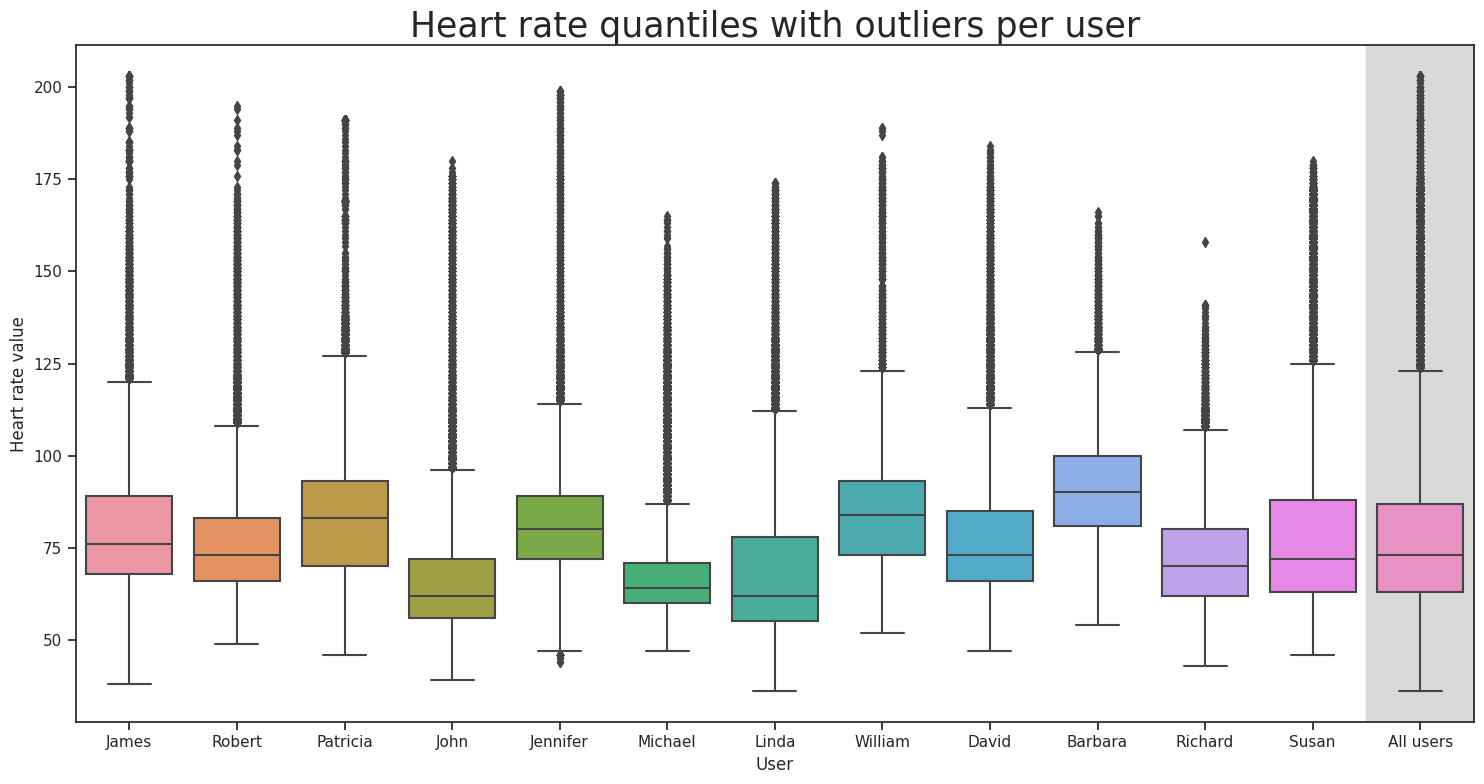

In [15]:
sns.set_theme(style="ticks")
fig, ax = plt.subplots(1, 1, figsize=(15,8), sharex=True, sharey=True)

df_heartrate_with_time_all = df_heartrate_with_time.copy()
df_heartrate_with_time_all['Name'] = 'All users'

sns.boxplot(data=pd.concat([df_heartrate_with_time, df_heartrate_with_time_all]), x='Name', y='Value', ax=ax)
ax.set_title('Heart rate quantiles with outliers per user', fontsize=25)
ax.set(
	ylabel='Heart rate value',
    xlabel='User'
)

num_names = df_heartrate_with_time['Name'].nunique()
ax.axvspan(num_names-0.5, num_names+0.5, color='0.85', zorder=-1)

fig.tight_layout()

In [16]:
df_heartrate_with_time['Value'].describe().apply(lambda x: format(x, 'f'))

count    2448397.000000
mean          77.114925
std           19.350302
min           36.000000
25%           63.000000
50%           73.000000
75%           87.000000
max          203.000000
Name: Value, dtype: object

In [17]:
df_heartrate_with_time.groupby(['Name'])['Value'].agg(['median', 'mean']).sort_values('median').T

Name,John,Linda,Michael,Richard,Susan,David,Robert,James,Jennifer,Patricia,William,Barbara
median,62.000000,62.000000,64.000000,70.000000,72.000000,73.000000,73.000000,76.00000,80.000000,83.000000,84.000000,90.000000
mean,66.132998,69.564516,68.633093,72.487484,83.611184,77.724045,76.722792,80.23686,81.673947,82.300577,83.749891,91.123795


#  1.2 Visualizing the Heart Rate of the users throughout the day

In [18]:
grouped_df = df_heartrate_with_time.groupby(['Id', 'Date', 'Hour', 'Minutes']).max().reset_index()

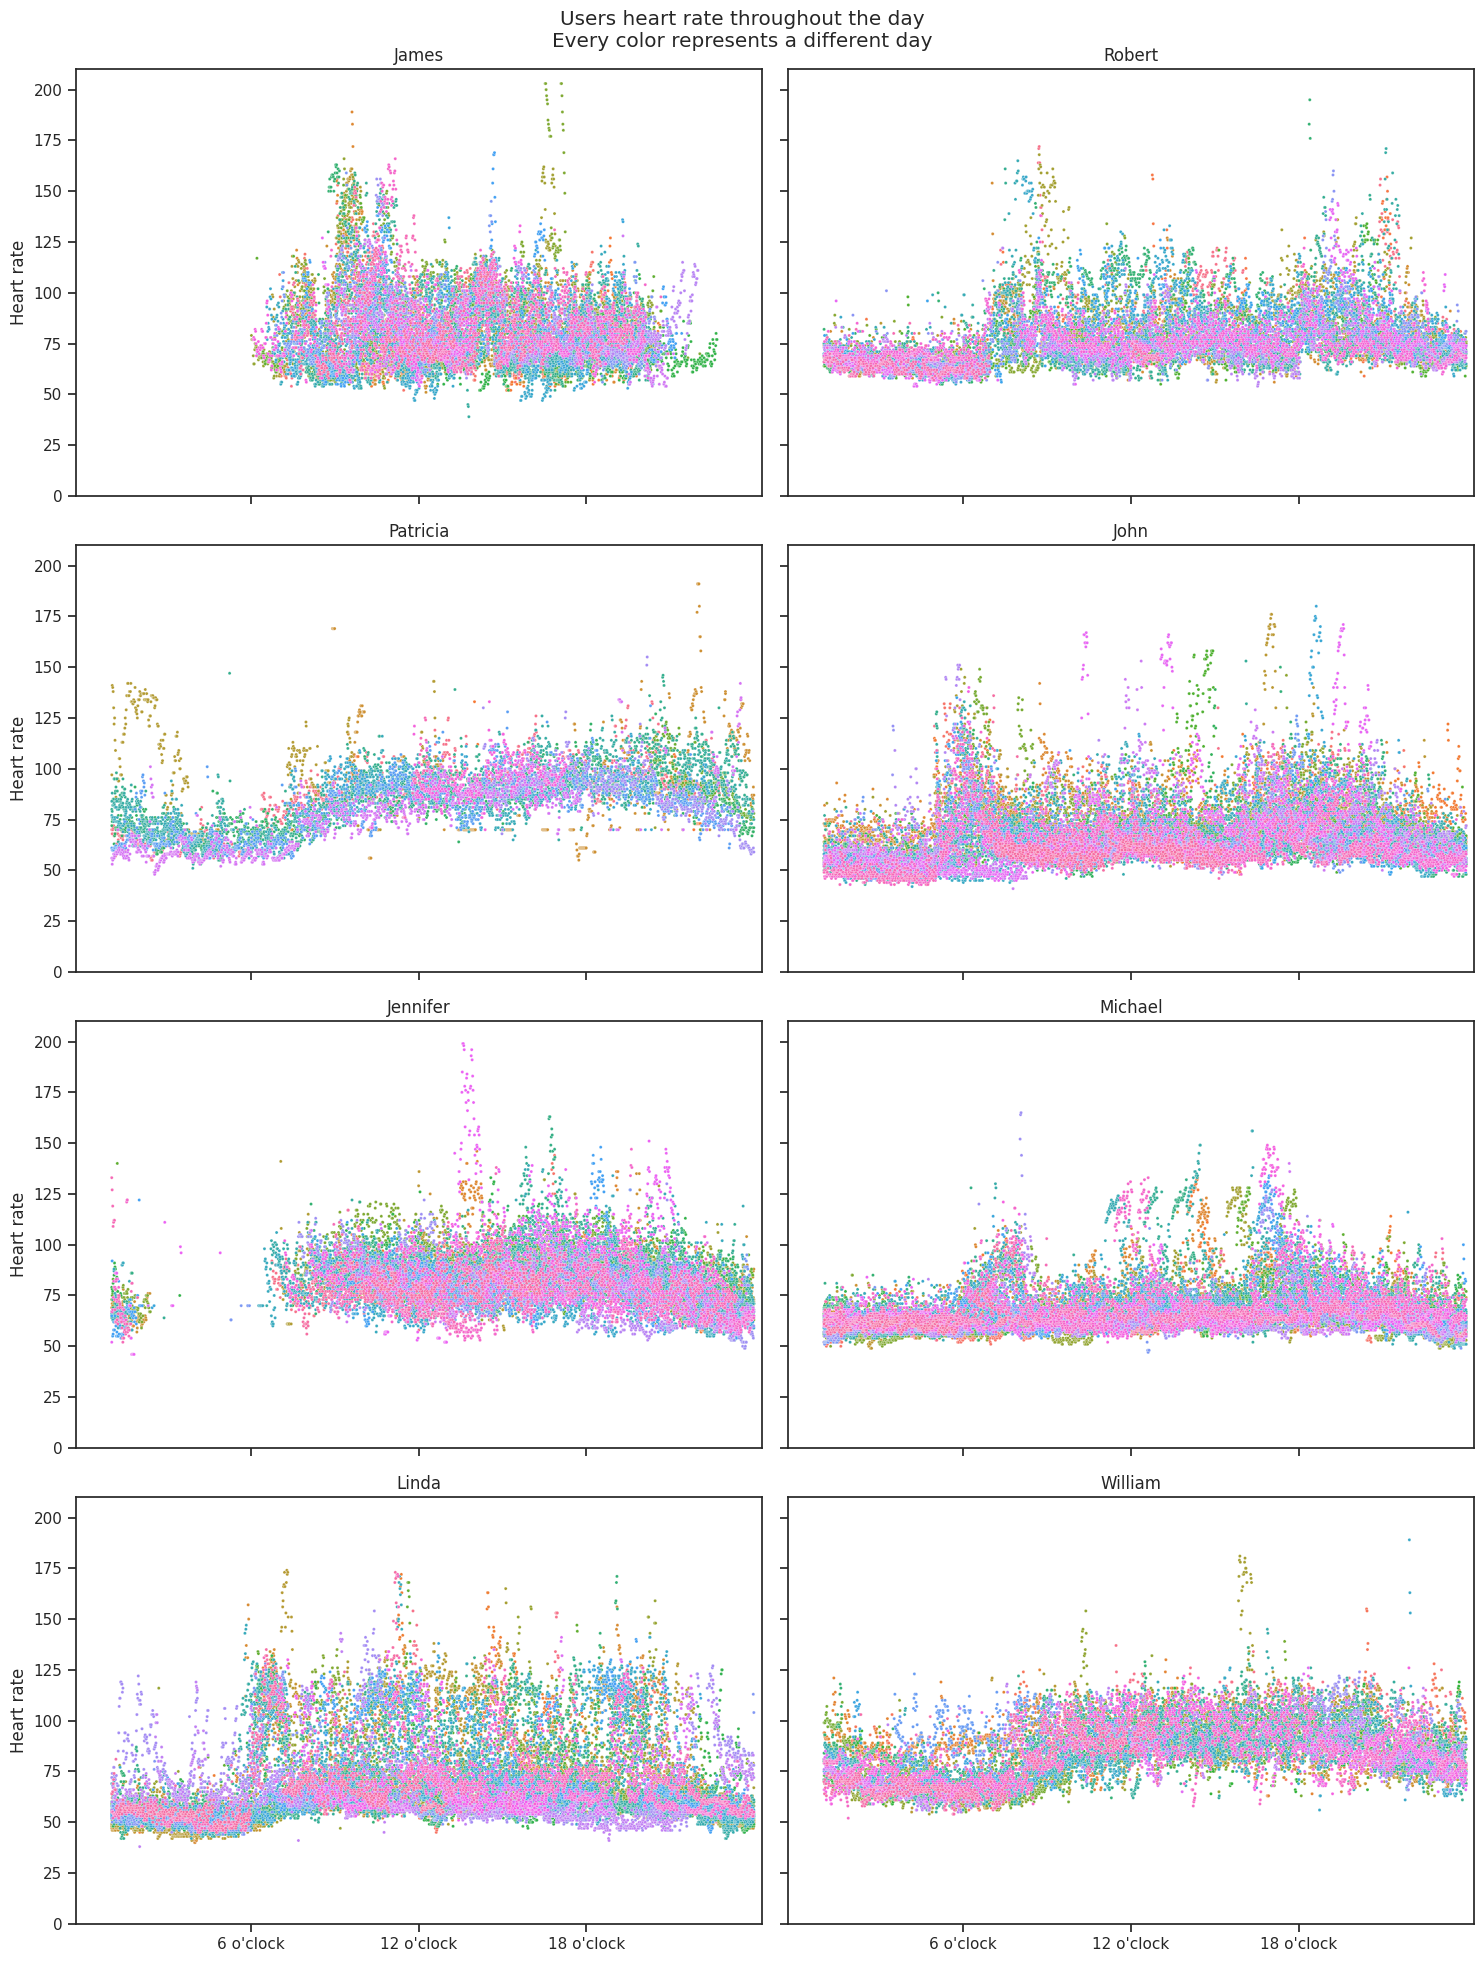

In [19]:
unique_names = df_heartrate_with_time['Name'].unique()
num_cols = 2
num_rows = 4 #int(np.ceil(len(unique_ids) // num_cols))

sns.set_theme(style="ticks")
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15,20), sharex=True, sharey=True)
axs = axs.flatten()

fig.suptitle('Users heart rate throughout the day\nEvery color represents a different day')

for i, i_name in enumerate(unique_names[:8]):
    ax = axs[i]
    i_df = grouped_df[grouped_df['Name'] == i_name]
    sns.scatterplot(data=i_df, x='time_of_day_in_seconds', y='Value', hue='Date', ax=ax, s=5)

    xticks = [c * 3600 for c in [6, 12, 18]] if (i >= (num_rows * num_cols - num_cols)) else []
    xticklabels = ['6 o\'clock', '12 o\'clock', '18 o\'clock'] if len(xticks) else []
    
    ax.set(
        xlabel='',
        ylabel='Heart rate',
        xlim=[-1000, 24*60*60+1000],
        ylim=[0, 210],
        xticks=xticks,
        xticklabels=xticklabels,
        title=i_name
    )

    ax.get_legend().remove()

fig.tight_layout()

# 1.3 Selecting a few user to take a closer look

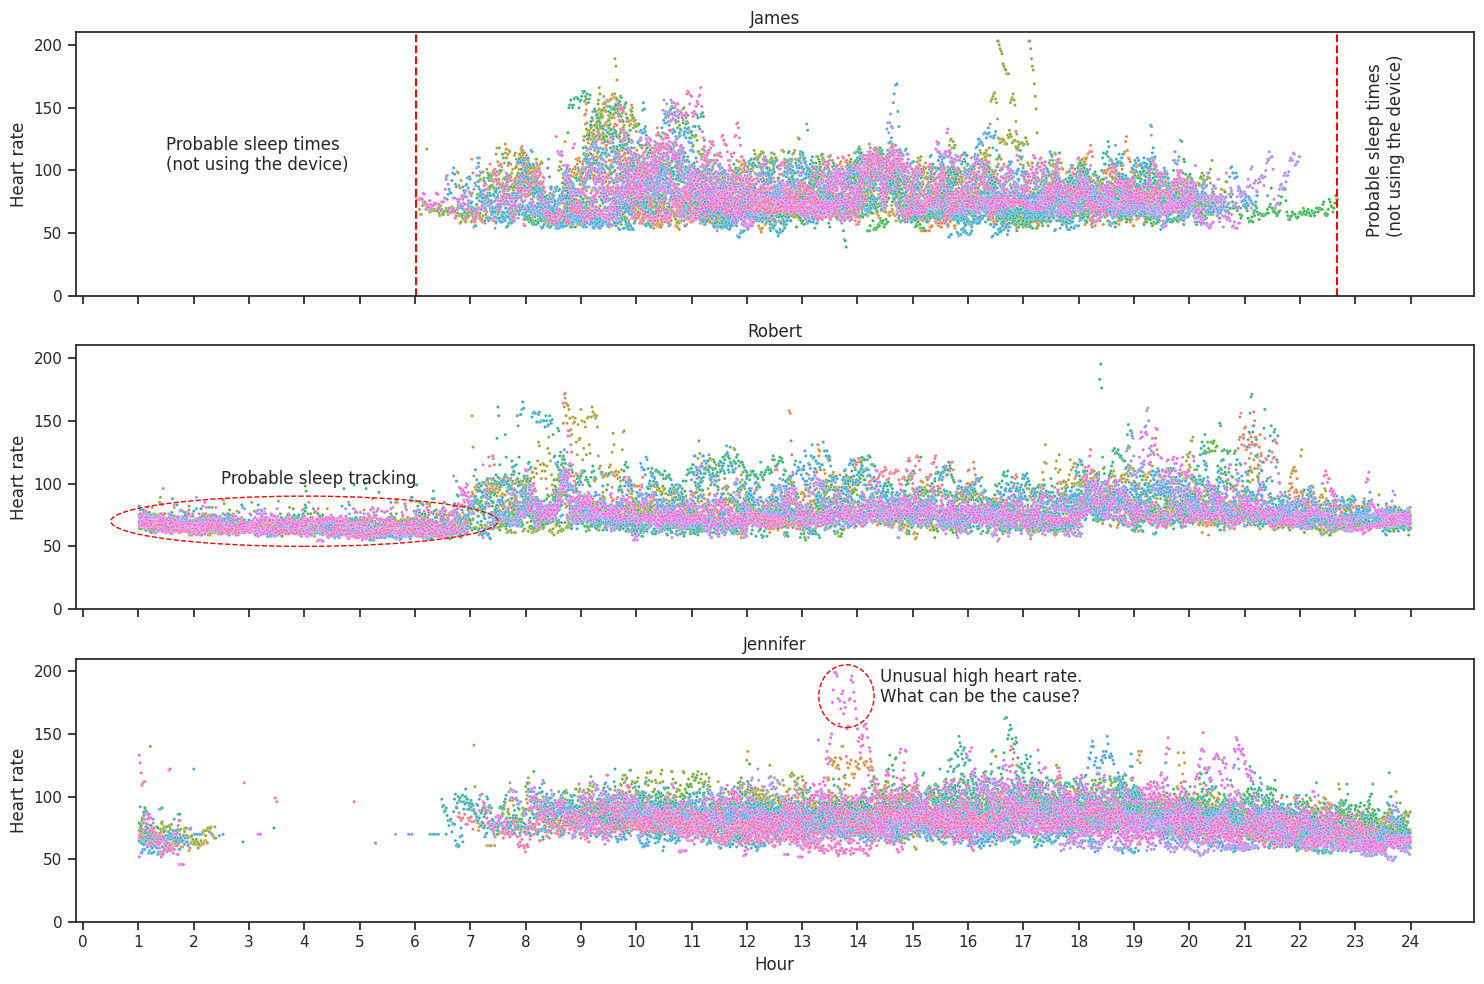

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(15,10), sharey=True, sharex=True)
axs = axs.flatten()

# Top graph
i_name = 'James'
ax = axs[0]
i_df = grouped_df[grouped_df['Name'] == i_name]
sns.scatterplot(data=i_df, x='time_of_day_in_seconds', y='Value', hue='Date', ax=ax, s=5)
ax.set(title=f'{i_name}')

ax.axvline(i_df['time_of_day_in_seconds'].min(), color='red', linestyle='dashed')
ax.axvline(i_df['time_of_day_in_seconds'].max(), color='red', linestyle='dashed')
ax.text(1.5 * 3600, 100,'Probable sleep times\n(not using the device)', fontsize=12)
ax.text(23.2 * 3600, 50,'Probable sleep times\n(not using the device)', fontsize=12, rotation='vertical')

# Middle graph
i_name = 'Robert'
ax = axs[1]
i_df = grouped_df[grouped_df['Name'] == i_name]
sns.scatterplot(data=i_df, x='time_of_day_in_seconds', y='Value', hue='Date', ax=ax, s=5)
ax.set(title=f'{i_name}')

elps = Ellipse((4 * 3600, 70), 7 * 3600, 40, edgecolor='red', facecolor='none', linestyle='dashed')
ax.add_artist(elps)
ax.text(2.5 * 3600, 100,'Probable sleep tracking', fontsize=12)

# Bottom graph
i_name = 'Jennifer'
ax = axs[2]
i_df = grouped_df[grouped_df['Name'] == i_name]
sns.scatterplot(data=i_df, x='time_of_day_in_seconds', y='Value', hue='Date', ax=ax, s=5)
ax.set(title=f'{i_name}')

elps = Ellipse((13.8 * 3600, 180), 1 * 3600, 50, edgecolor='red', facecolor='none', linestyle='dashed')
ax.add_artist(elps)
ax.text(14.4 * 3600, 175,'Unusual high heart rate.\nWhat can be the cause?', fontsize=12)

# All graphs settings
for i in range(3):
	axs[i].set(
		xlabel='Hour',
		ylabel='Heart rate',
		ylim=[0, 210],
		xticks=np.arange(25) * 3600,
		xticklabels=np.arange(25),
	)
	axs[i].get_legend().remove()

fig.tight_layout()

# 1.4 Investigating Jennifers high HR

In [21]:
# Which day did this high HR happened

df_heartrate_with_time.query('Name == "Jennifer" & Value > 165')['Date'].unique()

array([Timestamp('2016-05-08 00:00:00')], dtype=object)

In [22]:
# Isolating the data to work with

mask_jennifer = df_heartrate_with_time['Name'] == 'Jennifer'
mask_08052016 = df_heartrate_with_time['Date'].isin(df_heartrate_with_time.query('Name == "Jennifer" & Value > 165')['Date'].unique())
df_jennifer_080516 = df_heartrate_with_time[mask_jennifer & mask_08052016]
df_jennifer_080516.head()

,Id,Value,Date,Time,AM_PM,Name,time_of_day_in_seconds,Hour,Minutes,Seconds
1013129,4558609924,122,2016-05-08 00:00:00,8:39:20,PM,Jennifer,74360,20,39,20
1013130,4558609924,125,2016-05-08 00:00:00,8:39:25,PM,Jennifer,74365,20,39,25
1013131,4558609924,126,2016-05-08 00:00:00,8:39:30,PM,Jennifer,74370,20,39,30
1013132,4558609924,125,2016-05-08 00:00:00,8:39:35,PM,Jennifer,74375,20,39,35
1013133,4558609924,124,2016-05-08 00:00:00,8:39:40,PM,Jennifer,74380,20,39,40


In [23]:
# Bining the data in 5 minutes timespan

binning_minutes = 5
df_jennifer_080516.loc[:, 'time_bin'] = (pd.cut(df_jennifer_080516['time_of_day_in_seconds'],
                                                bins=np.arange(0, 24*3600+1, binning_minutes * 60),
                                                labels=np.arange(0, 24*3600, binning_minutes * 60)).astype('int'))

## 1.4.1 Loading more data (METs) to analyze the high HR

In [24]:
df_MET = pd.read_csv(data_dir + '/minuteMETsNarrow_merged.csv')
jennifer_id = int(df_heartrate.query('Name == "Jennifer"')['Id'].unique())
df_MET_jennifer = df_MET.query(f'(ActivityMinute.str.contains("5/8/2016")) & (Id == {jennifer_id})')
df_MET_jennifer = split_date_and_time_from_df(df_MET_jennifer, column='ActivityMinute')
df_MET_jennifer = add_column_time_in_seconds(df_MET_jennifer)

df_MET_jennifer.loc[:, 'time_bin'] = pd.cut(df_MET_jennifer['time_of_day_in_seconds'], bins=np.arange(0, 24*3600+1, 5 * 60), labels=np.arange(0, 24*3600, 5 * 60)).astype('int')
df_MET_jennifer.head()

,Id,METs,Date,Time,AM_PM,time_of_day_in_seconds,Hour,Minutes,Seconds,time_bin
707280,4558609924,10,2016-05-08 00:00:00,12:00:00,AM,43200,12,0,0,42900
707281,4558609924,10,2016-05-08 00:00:00,12:01:00,AM,43260,12,1,0,43200
707282,4558609924,10,2016-05-08 00:00:00,12:02:00,AM,43320,12,2,0,43200
707283,4558609924,10,2016-05-08 00:00:00,12:03:00,AM,43380,12,3,0,43200
707284,4558609924,10,2016-05-08 00:00:00,12:04:00,AM,43440,12,4,0,43200


## 1.4.2 Plotting Jennifer's HR against her METs

In [25]:
# Helper plotting function

def plot_min_max(data:pd.DataFrame, column_to_agg:str, column_value:str, c_ax: plt.Axes, colors:list=['black', 'grey']):
	df_agg = data.groupby(column_to_agg)[column_value].agg(['min', 'max', 'mean'])

	sns.lineplot(data=df_agg, x=column_to_agg, y="mean", color=colors[0], ax=c_ax)
	sns.lineplot(data=df_agg, x=column_to_agg, y="min", color=colors[1], ax=c_ax)
	sns.lineplot(data=df_agg, x=column_to_agg, y="max", color=colors[1], ax=c_ax)
	line = c_ax.lines
	c_ax.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color=colors[1], alpha=.5, )

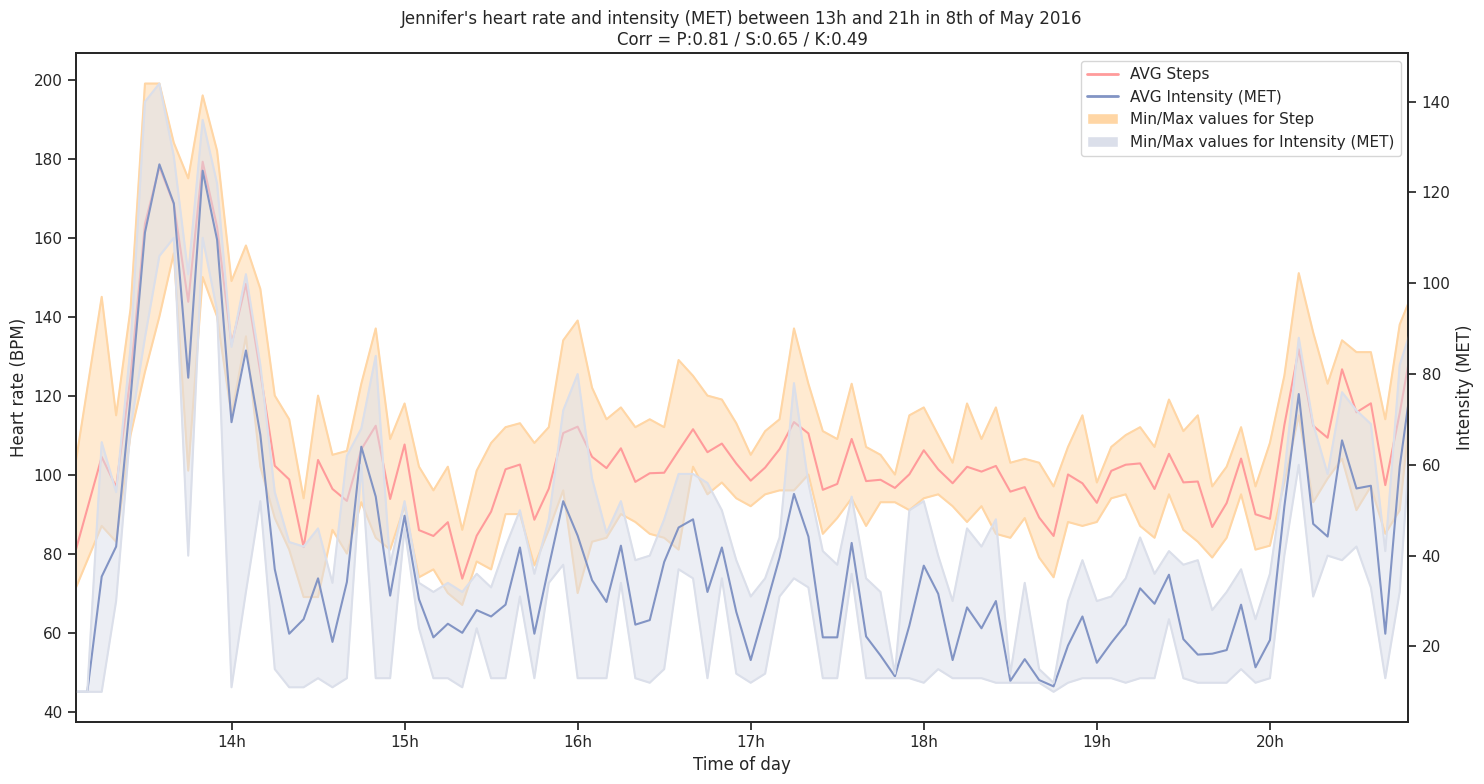

In [26]:
# Merging
merge_columns = ['Date', 'Id', 'time_bin']
df_corr = pd.merge(left=df_jennifer_080516, right=df_MET_jennifer[merge_columns + ['METs']], on=merge_columns)

# Selecting time of day we are interested in
df_corr = df_corr.query('(time_of_day_in_seconds > 13.2 * 3600) & (time_of_day_in_seconds < 21 * 3600)')[['Value', 'METs']]

# Correlations
corr_p = df_corr.corr().iloc[0,1]
corr_s = df_corr.corr(method='spearman').iloc[0,1]
corr_k = df_corr.corr(method='kendall').iloc[0,1]

# Plotting
fig, ax = plt.subplots(1,1, figsize=(15,8))
sns.set_theme(style='ticks')
ax2 = ax.twinx()

plot_min_max(data=df_jennifer_080516, column_to_agg='time_bin', column_value='Value', c_ax=ax, colors=['#FF9B9B', '#FFD6A5'])
plot_min_max(data=df_MET_jennifer, column_to_agg='time_bin', column_value='METs', c_ax=ax2, colors=['#8294C4', '#DBDFEA'])

ax.set(
    xticks=np.arange(25) * 3600,
    xticklabels=[f'{i}h' for i in np.arange(25)],
    xlim=[13.1 * 3600, 20.8 * 3600],
    title=(f'Jennifer\'s heart rate and intensity (MET) between 13h and 21h in 8th of May 2016\n'
            f'Corr = P:{corr_p:.2f} / S:{corr_s:.2f} / K:{corr_k:.2f}'),
    xlabel='Time of day',
    ylabel='Heart rate (BPM)'
)

ax2.set(
    ylabel='Activity intensity (MET)'
)

# Legend
custom_lines = [Line2D([0], [0], color='#FF9B9B', lw=2),
                Line2D([0], [0], color='#8294C4', lw=2),
                Patch(facecolor='#FFD6A5', label='Color Patch'),
                Patch(facecolor='#DBDFEA', label='Color Patch')]

ax.legend(custom_lines, ['AVG Steps', 'AVG Intensity (MET)', 'Min/Max values for Step', 'Min/Max values for Intensity (MET)'], loc=0)

ax2.set(
    ylabel='Intensity (MET)'
)

fig.tight_layout()

# 1.5 Checking the relationship between HR and METs

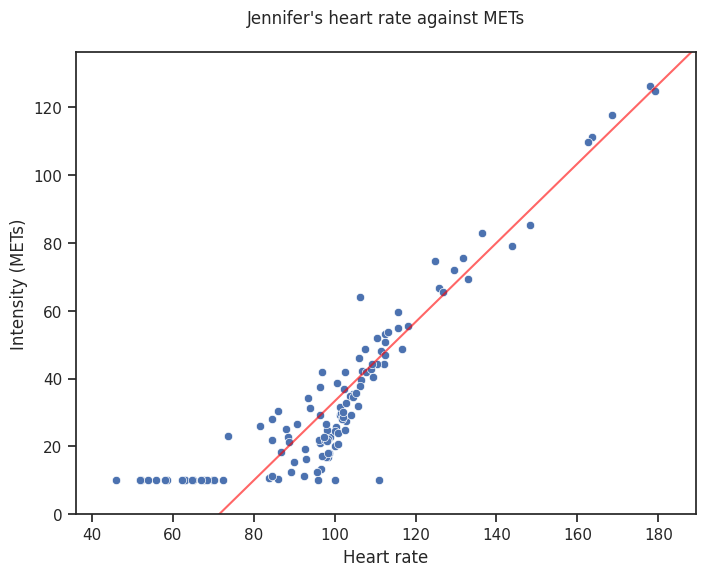

In [27]:
# Merge Jennifer HR and METs
df_MET_mean = df_MET_jennifer._get_numeric_data().groupby('time_bin').mean()
df_jennifer_hr_mean = df_jennifer_080516._get_numeric_data().groupby('time_bin').mean()
merged_jennifer = pd.merge(left=df_jennifer_hr_mean, right=df_MET_mean['METs'], left_index=True, right_index=True, how='inner')

# Plotting
fig, ax = plt.subplots(1,1, figsize=(8,6))

sns.scatterplot(data=merged_jennifer, x='Value', y='METs', ax=ax)

ax.set(
	title='Jennifer\'s heart rate against METs\n',
	ylabel='Intensity (METs)',
	xlabel='Heart rate',
    ylim=[0,merged_jennifer['METs'].max() + 10],
    xlim=[merged_jennifer['Value'].min() - 10, merged_jennifer['Value'].max() + 10],
);

# Linear regression
lrg = LinearRegression().fit(X=merged_jennifer.query('METs > 20')['Value'].values.reshape(-1, 1), y=merged_jennifer.query('METs > 20')['METs'])
x_pred = np.arange(40,200)
y_pred = lrg.predict(x_pred.reshape(-1,1))

sns.lineplot(x=x_pred, y=y_pred, ax=ax, color='red', alpha=0.6);